# Validate OpenBioLink Network
This notebook analysis the results of running the two versions of the algorithm (with and without cycles) on the OpenBioLink Network (original and permuted version) and validates the prioritized drug-disease pairs against ClinicalTrial data.

In [1]:
import os
import json
import getpass
import sys
import time
from collections import Counter, defaultdict
import logging

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['figure.dpi'] = 200

In [5]:
getpass.getuser()

'danieldomingo'

In [6]:
sys.version

'3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) \n[Clang 6.0 (clang-600.0.57)]'

In [7]:
time.asctime()

'Thu May 21 14:24:29 2020'

Load results for different lmax

In [8]:
def normalize_score(score):
    """Normalize score from [-1 to 1]."""
    return (1 - (-1)) * (score - 0) / (1 - 0) -1

def get_scores_for_pair(results):
    """Get scores for each pair as a pair to list dict.
    
    :param results: raw results from the JSON files
    """
    # Pairs to scores
    pairs_to_scores = defaultdict(list)
    
    # Pairs to the number of paths
    pairs_to_paths = defaultdict(list)
    
    # Pairs to the path of the last lmax
    pairs_to_last_path = {}    

    # Iterate over the results of each lmax
    for lmax, pairs in results.items():
        
        # Iterate over each pair and store the results
        for pair in pairs:
            
            if (pair['source'], pair['target']) not in pairs_to_last_path:
                pairs_to_last_path[(pair['source'], pair['target'])] = pair['number_of_paths']
                
            else:
                # The next Lmax hasnt increased the number of paths so we skip it cause it hasnt added any value
                if pairs_to_last_path[(pair['source'], pair['target'])] == pair['number_of_paths']:
                    
                    pairs_to_last_path[(pair['source'], pair['target'])] = pair['number_of_paths']
                    continue
                
                pairs_to_last_path[(pair['source'], pair['target'])] = pair['number_of_paths']

            pairs_to_scores[(pair['source'], pair['target'])].append(
                normalize_score(pair['relative_activation']), # Score [-1, 1]
            )
            
            pairs_to_paths[(pair['source'], pair['target'])].append(
                pair['number_of_paths']
            )
            

    return pairs_to_scores, pairs_to_paths

def parse_results(path_dir, prefix):
    """Parse directory with results."""
    results = {}
    
    for file in os.listdir(path_dir):
        
        if not file.endswith(".json") or not file.startswith(f"{prefix}all_against_all_lmax_"):
            continue

        lmax = int(file.replace(f"{prefix}all_against_all_lmax_", "").replace(".json", ""))

        with open(os.path.join(path_dir, file), 'r') as f:
            results[lmax] = json.load(f)

    # sort keys by lmax in case they have not been read in order
    results = {
        k: results[k]
        for k in sorted(results.keys())
    }
    
    if not results:
        raise ValueError("Couldnt load any results. Please ensure the valid path is given.")
        
    return get_scores_for_pair(results)

Get true positive pairs from Clinicaltrials.gov data

In [9]:
clinical_trials_info = pd.read_csv(
    "./validation_openbiolink.tsv",
    sep="\t",
)

true_positives = [
    (f"PUBCHEM.COMPOUND:{row['cid_id']}", row['do_id'])
    for _, row in clinical_trials_info.iterrows()
]

In [10]:
THRESHOLD = 0.5

In [11]:
def get_prioritized_pairs(results, true_positives, name, lmax_range, fails_allowed, threshold, reverse=False):
    """Get prioritized pairs from all results."""
    consistent_pairs_labels = {}
        
    pairs_to_scores = results[0]
    pairs_to_paths = results[1]

    for pair, scores in pairs_to_scores.items():
        
        # Scores range from [-1 to 1]. -1 if fully activation and +1 fully inhibition

        # Reverse (to search drugs that activate the disease) (+1 scores)
        if reverse:
            if not all(score > threshold for score in scores):
                continue
                
        # Normal (to search drugs that inhibit the disease) (-1 scores)
        else: 
            if not all(score < threshold for score in scores):
                continue
                
        # There is a path for all lmax
        if len(scores) < (lmax_range - fails_allowed):
            continue  
            
        consistent_pairs_labels[pair] = 1 if pair in true_positives else 0
        
#         logger.warning(f"Paths for {pair}: {pairs_to_paths[pair]}")
    
    labels_distribution = Counter(consistent_pairs_labels.values())
    
    if not consistent_pairs_labels:
        print(f"No consistent pairs for {name}")
        return None

    print(
        f"Prioritized pairs for {name}: {dict(labels_distribution)} (%0.2f)" % ((labels_distribution[1] * 100) / len(consistent_pairs_labels))
    )
    
    return consistent_pairs_labels

In [12]:
fails_allowed = 1

Find the drug-disease pairs that are consistently inhibited independently of Lmax

In [13]:
"""Original version with simple paths"""
simple_paths_original_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/simple_paths/openbiolink/", "openbiolink"),
    true_positives=true_positives,
    name="OpenBioLink Simple Paths",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=-THRESHOLD,
)

"""Original version with cycles"""
cycles_original_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/cycles/openbiolink/", "openbiolink"),
    true_positives=true_positives,
    name="OpenBioLink With Cycles",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=-THRESHOLD,
)

"""Permuted version with cycles"""
cycles_permuted_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/cycles/openbiolink_random/", "openbiolink"),
    true_positives=true_positives,
    name="Permutated With Cycles",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=-THRESHOLD,
)

"""Permuted version with simple paths"""
reverse_cycles_permuted_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/simple_paths/openbiolink_random/", "shuffled_openbiolink"),
    true_positives=true_positives,
    name="Permutated Simple Paths",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=-THRESHOLD,
)

Prioritized pairs for OpenBioLink Simple Paths: {1: 2, 0: 2} (50.00)
Prioritized pairs for OpenBioLink With Cycles: {0: 10, 1: 1} (9.09)
No consistent pairs for Permutated With Cycles
No consistent pairs for Permutated Simple Paths


In [14]:
"""Original version with simple paths"""
reverse_simple_paths_original_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/simple_paths/openbiolink/", "openbiolink"),
    true_positives=true_positives,
    name="OpenBioLink Simple Paths",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=THRESHOLD,
    reverse=True,
)

"""Original version with cycles"""
reverse_cycles_original_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/cycles/openbiolink", "openbiolink"), 
    true_positives=true_positives,
    name="OpenBioLink With Cycles",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=THRESHOLD,
    reverse=True,
)

"""Permuted version with cycles"""
reverse_cycles_permuted_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/cycles/openbiolink_random", "openbiolink"),
    true_positives=true_positives,
    name="Permutated With Cycles",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=THRESHOLD,
    reverse=True,
)

"""Permuted version with simple paths"""
reverse_cycles_permuted_openbiolink = get_prioritized_pairs(
    results=parse_results("/Users/danieldomingo/Downloads/drug2ways/simple_paths/openbiolink_random", "shuffled_openbiolink"),
    true_positives=true_positives,
    name="Permutated Simple Paths",
    lmax_range=7,
    fails_allowed=fails_allowed,
    threshold=THRESHOLD,
    reverse=True,
)

Prioritized pairs for OpenBioLink Simple Paths: {0: 2, 1: 1} (33.33)
Prioritized pairs for OpenBioLink With Cycles: {0: 5, 1: 4} (44.44)
No consistent pairs for Permutated With Cycles
No consistent pairs for Permutated Simple Paths


# Overlap of the prioritized pairs

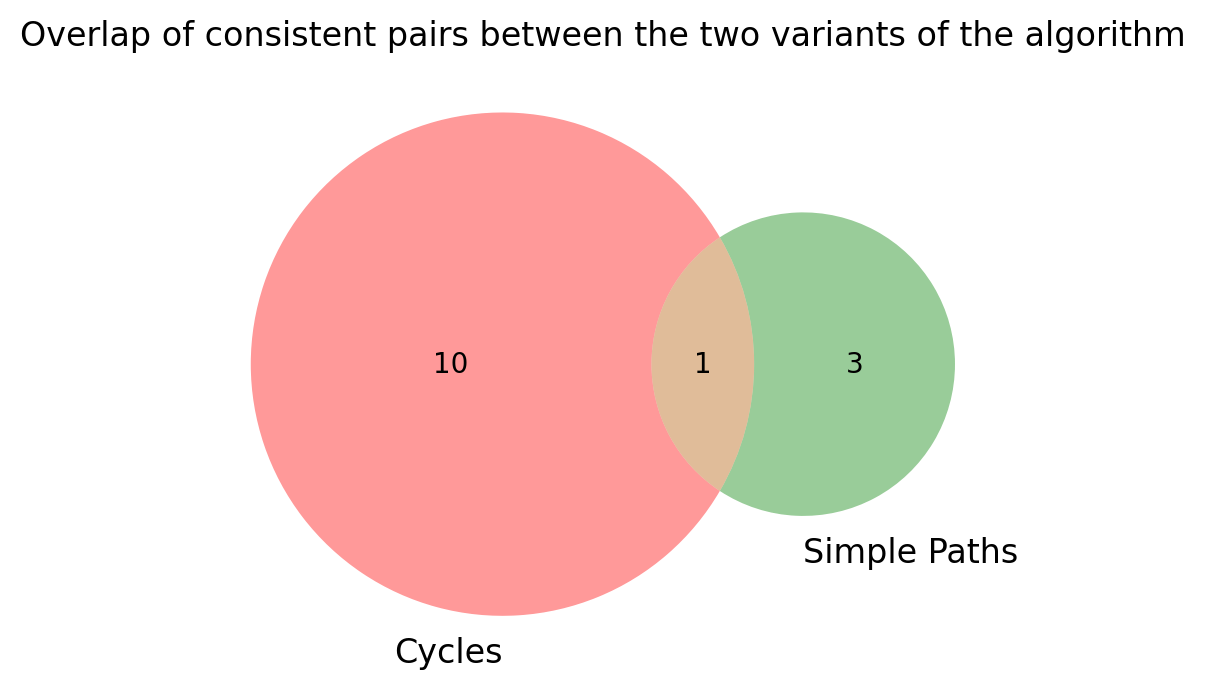

In [15]:
venn2(
    [set(cycles_original_openbiolink.keys()), set(simple_paths_original_openbiolink.keys())],
    set_labels = ('Cycles', 'Simple Paths'),
)
plt.title("Overlap of consistent pairs between the two variants of the algorithm")
plt.show()

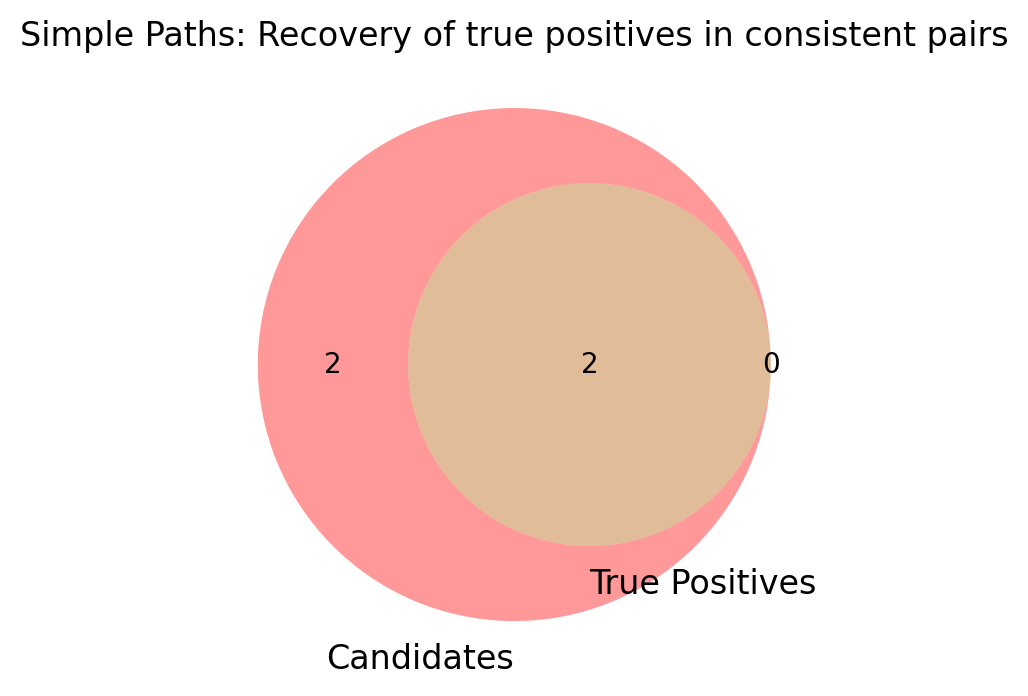

In [16]:
venn2(
    [
        set(simple_paths_original_openbiolink.keys()),
        set(simple_paths_original_openbiolink.keys()).intersection(set(true_positives))
    ],
    set_labels = ('Candidates', 'True Positives'),
)
plt.title("Simple Paths: Recovery of true positives in consistent pairs")
plt.show()

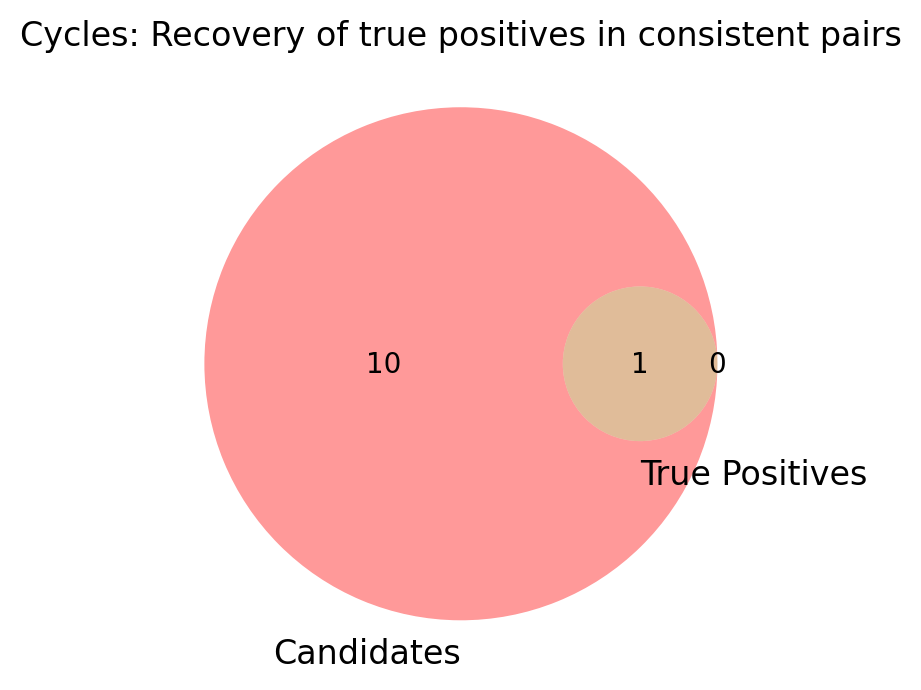

In [17]:
venn2(
    [
        set(cycles_original_openbiolink.keys()),
        set(cycles_original_openbiolink.keys()).intersection(set(true_positives))
    ],
    set_labels = ('Candidates', 'True Positives'),
)

plt.title("Cycles: Recovery of true positives in consistent pairs")
plt.show()

Export the results common between the two variation of the algorithm

In [18]:
results_df = pd.DataFrame([
    {"drug": drug, "disease": disease, "true_positive": "true" if (drug, disease) in true_positives else "false"}
    for (drug, disease) in set(cycles_original_openbiolink.keys()).intersection(set(simple_paths_original_openbiolink.keys()))
])

In [19]:
results_df.shape

(1, 3)

In [20]:
results_df.head()

,drug,disease,true_positive
0,PUBCHEM.COMPOUND:772,DOID:678,false


In [21]:
results_df.to_csv(
    "results_openbiolink.tsv",
    sep='\t',
    index=False
)